# Forecasting Electricity Demand

## Motivation

On $3^{rd}$ April 2020, as Indians were entering the 3rd week of the first covid-19 lockdown, PM Narendra Modi took to social media and twitter asking citizens to switch of their lights and light diyas for 9 minutes at 9pm on $5^{th}$ April 2020, in order to show solidarity with the healthcare and the frontline workers. This was reiterated by hundreds of thousands of prominent persons and celebrities. A major proportion of the citizens of the country of 138 crore population were expected to be a part of it. This led to the fear of a major power grid faliure due to sudden drop and surge in demand. As a result the states had to scramble for preparation of the event, issuing detailed orders to prevent disruptions.

The above case is an example of how important it is to anticipate potential surges and drop in electricity consumption. A power faliure affects not only the production process and industries but also hospitals and other essential functions. Forecasting the demand for electricity is important in order to build enough capacity and prevent power faliures. This is because storing electricity is still expensive and thus it has to be generated as per demand. This forecasting can be in long run, short run or over a medium run period. I use ARMA model on yearly data from UK's electricity board for prediction of total electricity demanded. This analysis can be further extended to include other variables such as the price of electricity, production of the country, availability of fuel, and other social and demand related variables.

## Data

I take data from Digest of United Kingdom Energy Statistics(DUKES) dataset which contains data on fuel inputs, Supply, Avaliability and consumption, Electricity generated and supplied, capacity, margin and prices. On the demand side is further divided into domestic and industrial demand.

## Model

Bases on minimum AIC, I try to fit ARMA(1,5) and ARMA(1,1) models given by:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib notebook

In [3]:
path = r"C:\Users\parik\Documents\Data sets\Time series course\sac_elect.csv"
df = pd.read_csv(path,index_col=0)
df.head()

Electricity supplied(net)  Purchases from other producers  Net imports  \
Year                                                                           
1920                      3.976                           0.089          0.0   
1921                      3.605                           0.059          0.0   
1922                      4.226                           0.150          0.0   
1923                      4.928                           0.249          0.0   
1924                      5.627                           0.272          0.0   

      Electricity Available  Losses in transmission  Total loss  \
Year                                                              
1920                  4.065                     NaN         NaN   
1921                  3.664                     NaN         NaN   
1922                  4.376                     NaN         NaN   
1923                  5.177                     NaN         NaN   
1924                  5.899                     NaN         NaN   

      Fuel industries  Industrial  Domestic  Other  Total  
Year                                                       
1920              NaN         NaN       NaN    NaN    NaN  
1921              NaN         NaN       NaN    NaN    NaN  
1922              NaN         NaN       NaN    NaN    NaN  
1923              NaN         NaN       NaN    NaN    NaN  
1924              NaN         NaN       NaN    NaN    NaN

# Preliminary Analysis

### We try to model the total electricity demand since 1970

<IPython.core.display.Javascript object>


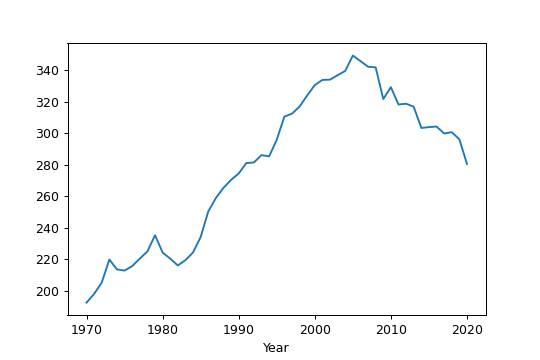

In [4]:
exog = df['Total'][50:].plot()

Taking first difference, we get

<IPython.core.display.Javascript object>


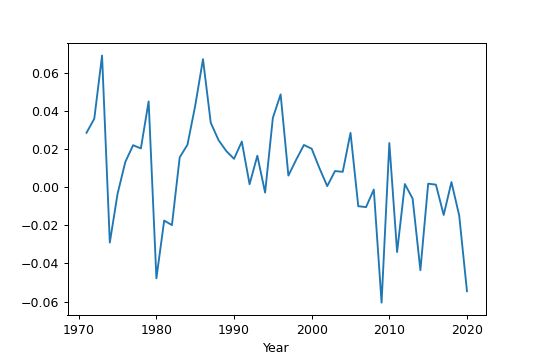

<AxesSubplot:xlabel='Year'>

In [5]:
plt.figure()
exog = np.log(df['Total'][50:]).diff(1)[1:]
exog.plot()

<IPython.core.display.Javascript object>


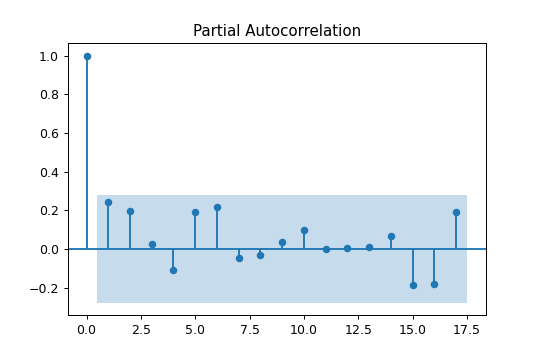

<IPython.core.display.Javascript object>


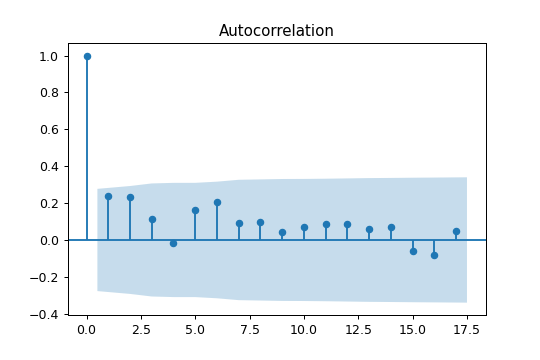

In [6]:
plot_pacf(exog);
plot_acf(exog);

In [7]:
ad_fuller_result = adfuller(exog)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.047705456295545
p-value: 0.030673152466244902


In [8]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Choose model based on minimum aic criterion

In [9]:
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(0, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=exog)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

(p, d, q)         AIC
0   (1, 0, 1) -216.617195
1   (1, 0, 5) -215.058841
2   (1, 0, 0) -214.799224
3   (1, 0, 2) -214.401045
4   (1, 0, 3) -212.240903
..        ...         ...
59  (1, 6, 1)    0.587129
60  (1, 7, 2)   11.378401
61  (1, 6, 0)   45.512645
62  (1, 7, 1)   53.016293
63  (1, 7, 0)   96.502756

[64 rows x 2 columns]

We model ARMA(1,5) and ARMA(1,1)

## Estimating ARMA(1,5)

In [10]:
ma_1 = ARIMA(exog, order=(1,0,5)).fit()
print(ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   50
Model:                 ARIMA(1, 0, 5)   Log Likelihood                 114.646
Date:                Tue, 01 Mar 2022   AIC                           -213.291
Time:                        12:14:21   BIC                           -197.995
Sample:                             0   HQIC                          -207.466
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.012      0.509      0.610      -0.018       0.030
ar.L1          0.8913      0.207      4.299      0.000       0.485       1.298
ma.L1         -0.7377      0.232     -3.185      0.0

Coefficients are not significant after the 2nd lag

## Estimating ARMA(1,1)

In [11]:
arma_11 = ARIMA(exog, order=(1,0,1)).fit()
print(arma_11.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   50
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 111.474
Date:                Tue, 01 Mar 2022   AIC                           -214.947
Time:                        12:14:29   BIC                           -207.299
Sample:                             0   HQIC                          -212.035
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.011      0.577      0.564      -0.015       0.027
ar.L1          0.9041      0.189      4.783      0.000       0.534       1.274
ma.L1         -0.7313      0.268     -2.726      0.0

We can see that ARMA(1,1) has minimum aic and the coefficients are also significant.

Going further we can see that we can further improve the model by incorporating breaks.